Found 8859 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - accuracy: 0.7454 - loss: 0.4983 - val_accuracy: 0.8179 - val_loss: 0.3886 - learning_rate: 1.0000e-04
Epoch 2/10
  1/276 ━━━━━━━━━━━━━━━━━━━━ 7:45 2s/step - accuracy: 0.8438 - loss: 0.2912

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8438 - loss: 0.2912 - val_accuracy: 0.8333 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9000 - loss: 0.2467 - val_accuracy: 0.8148 - val_loss: 0.3809 - learning_rate: 1.0000e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.1698 - val_accuracy: 1.0000 - val_loss: 0.0211 - learning_rate: 1.0000e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9185 - loss: 0.1999 - val_accuracy: 0.8356 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8750 - loss: 0.2625 - val_accuracy: 1.0000 - val_loss: 0.0544 - learning_rate: 1.0000e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.9471 - loss: 0.1419 - val_accuracy: 0.8990 - val_loss: 0.3039 - learning_rate: 1.0000e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9688 -

C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step
Accuracy: 0.511743450767841
Precision: 0.5308291991495393
Recall: 0.6412671232876712
F1 Score: 0.5808452888716557


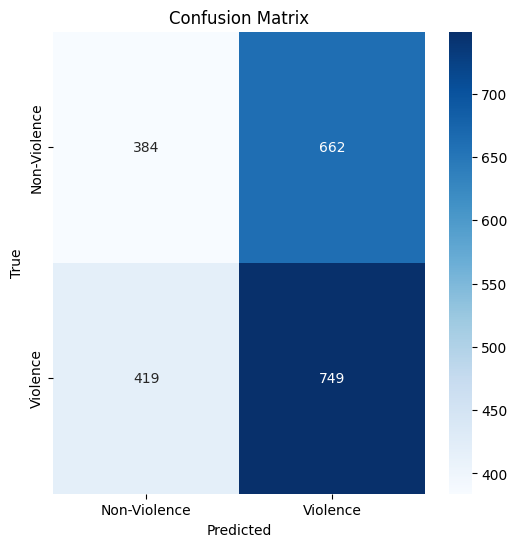

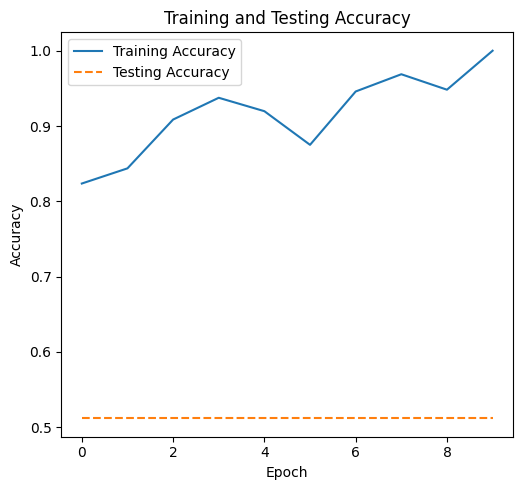

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, GlobalAveragePooling2D, Dropout, LayerNormalization, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create Transfer Learning Autoencoder (VGG16 as Encoder)
def create_transfer_learning_autoencoder(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[:-4]:  # Fine-tune the last 4 layers
        layer.trainable = False
    
    # CNN block output
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling for spatial reduction
    cnn_output = Dense(256, activation='relu')(x)  # Additional dense layer

    return base_model.input, cnn_output

# Transformer block
def transformer_block(inputs, num_heads=4, ff_dim=256):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    transformer_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    return transformer_output

# Hybrid CNN-Transformer Model
def create_hybrid_model(input_shape):
    # CNN Block (VGG16-based)
    cnn_input, cnn_output = create_transfer_learning_autoencoder(input_shape)

    # Reshape CNN output to add a sequence dimension (needed for the transformer)
    cnn_output_reshaped = Reshape((1, -1))(cnn_output)

    # Transformer Block
    transformer_output = transformer_block(cnn_output_reshaped)
    transformer_output_flat = Reshape((-1,))(transformer_output)  # Flatten the transformer output

    # Output layer
    outputs = Dense(1, activation='sigmoid')(transformer_output_flat)

    # Full hybrid model
    model = Model(cnn_input, outputs)
    return model

# Compile the model
def compile_hybrid_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Test the model and calculate performance metrics
def test_model(model, test_generator):
    # Predict on the test set
    predictions = model.predict(test_generator)
    predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

    # True labels
    true_labels = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violence', 'Violence'], yticklabels=['Non-Violence', 'Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

# Main function to execute workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Path to dataset
    input_shape = (224, 224, 3)

    # Create and compile the hybrid model
    hybrid_model = create_hybrid_model(input_shape)
    compile_hybrid_model(hybrid_model)

    # Use ImageDataGenerator for data loading and augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        zoom_range=0.3,
        validation_split=0.2  # Split 30% for testing, 70% for training
    )

    batch_size = 32

    # Train and validation data generators
    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    val_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the hybrid model
    history = hybrid_model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=val_generator.samples // batch_size,
        epochs=10,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Testing accuracy
    print("Testing the hybrid model...")
    test_accuracy, precision, recall, f1 = test_model(hybrid_model, val_generator)

    # Plot training and testing accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot([test_accuracy] * len(history.history['accuracy']), label='Testing Accuracy', linestyle='--')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
